# Mini Lab: SVM and Logistic Regression Modeling

### Teammates: Chad Kwong, Erin McClure-Price, Alex Lopez, Chris Haub

## Initial loading of dataset and all related packages

The first step was to load necessary packages and the dataset. In addition, we created a series of variables for indexing both the continuous and categorical variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
import glob
import os

#Suppress futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

#Import Dataset from github repo
bankData = pd.read_csv('bank-additional-full.csv', sep=';', na_values="unknown")
#Optional: Add in index column
#bankData.insert(0, 'Sample_ID', range(1,len(bankData)+1))

#Creating variables for indexing continuous and categorical variables
conCol = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
catCol = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
          'contact', 'month', 'day_of_week', 'poutcome', 'y']

The next step was to drop entries with missing values, this removed #### rows leaving 30,488 rows for analysis. In addition, we removed the 'default' column because it consisted of entirely 'no' responses and a total of 3 'yes' responses.

In [2]:
bankData2 = bankData.dropna()
#remove 'default' column
bankData2.drop(['default'], axis=1)
bankData2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


We double checked the dataset to ensure that all missing values had been removed.

In [3]:
# checked for missing values, no missing values
bankData2.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Checking the shape of the data showed that we had a total of 30,488 rows and 21 attributes in our cleaned dataset.

In [4]:
bankData2.shape

(30488, 21)

Before we could build a model, we needed to create a dataframe with the target variable, y, which was whether a customer decided to take on a long term deposit.

In [5]:
#define the target variable
y = bankData2.y
y.head()

0    no
2    no
3    no
4    no
6    no
Name: y, dtype: object

The dataset is a mixture of both continuous, numeric, and categorical data, therefore we chose to separate the categorical attributes into a separate dataframe and apply One Hot Encoding to convert categorical entries to numeric data. The converted dataframe was concatenated back into the original dataframe and the original attributes were removed.

In [6]:
# one hot encoding of ALL categorical variables

# pd.concat([*]], axis=1) // this line of code concatenates all the data frames in the [*] list
# [** for col in categ_features] // this steps through each feature in categ_features and 
#                                //   creates a new element in a list based on the output of **
# pd.get_dummies(df_imputed[col],prefix=col) // this creates a one hot encoded dataframe of the variable=col (like code above)

categ_features = ['job','marital','education','default','housing','loan','contact','month','poutcome'];

OneHotDF = pd.concat([pd.get_dummies(bankData2[col],prefix=col,drop_first=True) for col in categ_features], axis=1)

OneHotDF.head()

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/01.%20Pandas.ipynb

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


# Creating and Adjusting Models

Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use
80/20 training/testing split for your data). Adjust parameters of the models to make them more
accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel
only is fine to use. 

## Logistic Regression

Before building the models, we first separated out the Features and the Target for establishing testing and training sets. 

In [7]:
# Separating out the features for training and testing
X = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1)
X = X.values

# Separating out target for training and testing
Y = bankData2.pop("y")
Y = Y.values.ravel()


Once the features were separated, we performed hold out cross validation with 3 splits using a basic Logistic Regression model. We then compared accuracies between iterations of cross validation performed on the test and training splits. The random state was set to 1 for replicability.

In [23]:
#Cross validation, using 80/20 train/test splitting
splits = 3
randomState=1
cv = ShuffleSplit(n_splits=splits, test_size=0.20, random_state=randomState)

#Creating standard scaler object
scl_obj = StandardScaler()

#Creating Logistic Regression object
lr_clf = LogisticRegression(random_state=randomState)

#Setting Iteration start point for for loop
iter_num=1

#For loop for creating testing and training sets and running a full basic LR model to compare iterations the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv.split(X,Y): 
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    
    X_test = X[test_indices]
    Y_test = Y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 
    
    lr_clf.fit(X_train_scaled, Y_train)  # train object
    y_hat = lr_clf.predict(X_test_scaled) # get test set precitions
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print('accuracy:', acc )
    print("confusion matrix\n",conf)
    #print(conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
    

# https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


====Iteration 1  ====
accuracy: 0.9022630370613316
confusion matrix
 [[5172  164]
 [ 432  330]]
====Iteration 2  ====
accuracy: 0.9050508363397836
confusion matrix
 [[5188  157]
 [ 422  331]]
====Iteration 3  ====
accuracy: 0.8934076746474254
confusion matrix
 [[5099  170]
 [ 480  349]]


We then hypertuned the parameters of our logistic regression model using the following interactive code. Accuracy values will vary from above due to slight differences the training and test sets generated from the hold out cross validation. Our focus is on what changes to parameters improve the general model, so these small differences do not have an impact.

In [25]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def exploreLogisticRegression(penMethod, cost, algorithm, maxIterations, dualOption, tolerance):
    model = LogisticRegression(random_state=randomState,
                               penalty='l2',
                               C=cost,
                               solver=algorithm,
                               max_iter = maxIterations,
                               dual = dualOption,
                               tol = tolerance * 1e-4)
    acc = cross_val_score(model,X,y=y,cv=cv)
    print("\n\nUsing the settings above:\n\nThe first iteration accuracy is",acc[0])
    print("The second iteration accuracy is",acc[1])
    print("The third iteration accuracy is",acc[2])

print('Logistic Regression Parameter Tuning:')
#Default values:
#PenMethod = l2, cost = 1, algorithm = lbfgs, maxIterations = 100
#verboseN = 0, dualOption = False, tolerance = 1e-4 or 1 on the sliders,
#
wd.interact(exploreLogisticRegression,
            penMethod=['l2','l1','elasticnet', 'none'],
            cost=(0.001,5,0.05),
            algorithm = ['liblinear', 'saga', 'sag', 'newton-cg', 'lbfgs'],
            maxIterations = (50,500,10),
            dualOption = [False, True],
            tolerance = (1,10,1),
            __manual=True)

Logistic Regression Parameter Tuning:


interactive(children=(Dropdown(description='penMethod', options=('l2', 'l1', 'elasticnet', 'none'), value='l2'…

<function __main__.exploreLogisticRegression(penMethod, cost, algorithm, maxIterations, dualOption, tolerance)>

Once we hypertuned our model, we then constructed a full model to generate the accuracy and confusion matrix.

In [10]:
finalModel = LogisticRegression(penalty='l2', C=0.05, solver='liblinear')
finalModel.fit(X_train_scaled,Y_train)
y_hat = finalModel.predict(X_test_scaled)
acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
print('accuracy:', acc )
print("Confusion Matrix:\n",conf,"\n")

accuracy: 0.8925877336831748
Confusion Matrix:
 [[5103  166]
 [ 489  340]] 



## Support Vector Machines

In [12]:
#Training the model
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, Y_train)

#Generating Predictions
y_hat = svm_clf.predict(X_test_scaled)

#calculating accuracy and confusion matrix and printing the two
acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
print('accuracy:', acc )
print("Confusion Matrix:\n",conf,"\n")

#Printing Support Vector shapes and information
print("The shape of the support vectors is ",svm_clf.support_vectors_.shape)
print("The indices of support vectors are",svm_clf.support_.shape)
print("The numbers of support vectors for each class are",svm_clf.n_support_, "\n")

accuracy: 0.8888160052476222
Confusion Matrix:
 [[5127  142]
 [ 536  293]] 

The shape of the support vectors is  (5792, 43)
The indices of support vectors are (5792,)
The numbers of support vectors for each class are [3019 2773] 



<ipython-input-13-5d98bcc1931f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankData2["y"] = Y # also add it back in for the original data


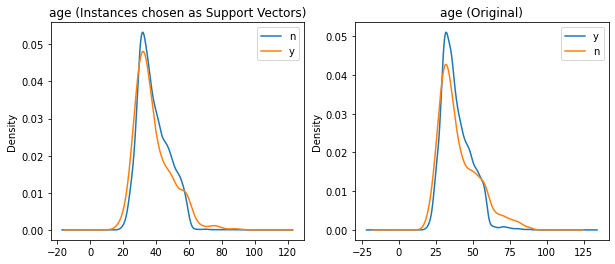

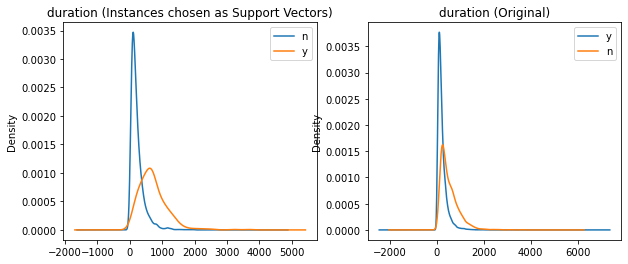

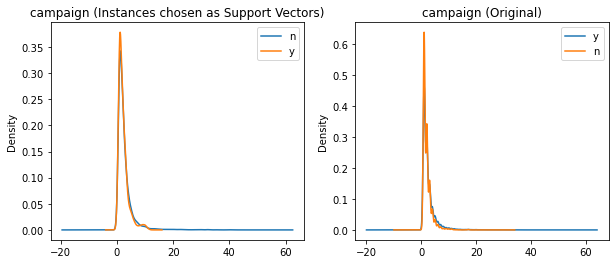

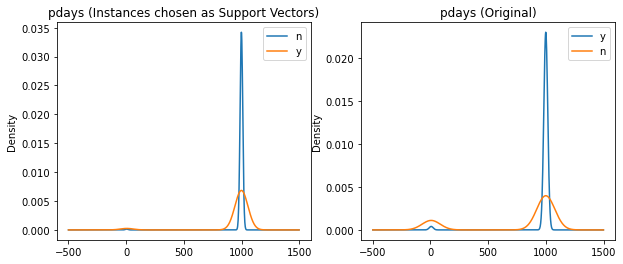

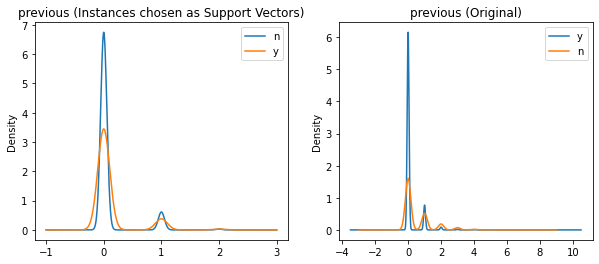

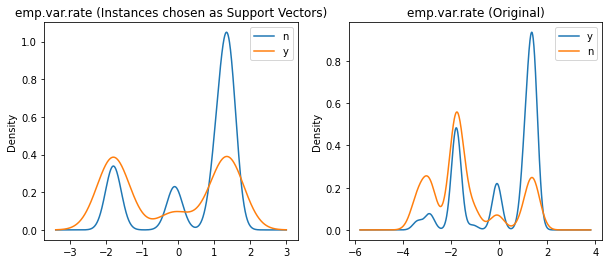

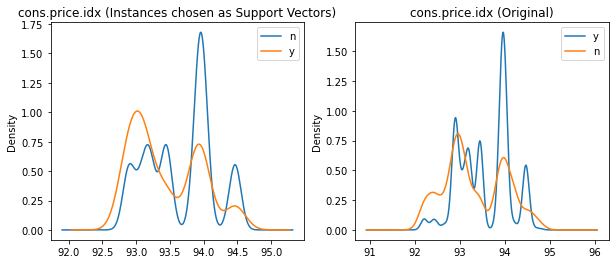

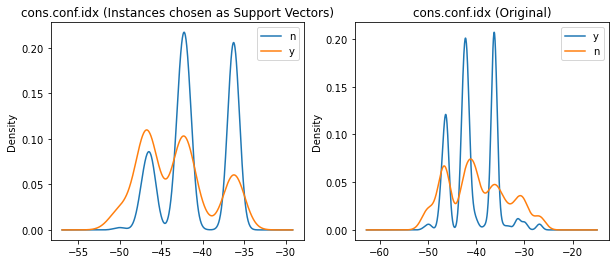

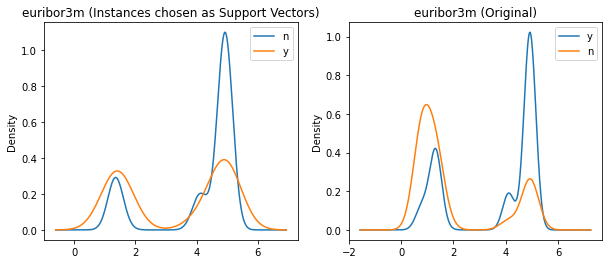

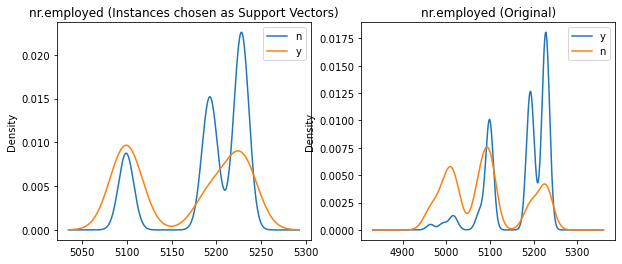

In [13]:
# make a dataframe of the training data
df_tested_on = bankData2.iloc[train_indices].copy() # saved from above, the indices chosen for training
# getting the support vectors from the trained model
df_support = bankData2.iloc[svm_clf.support_,:].copy()

#Adding y column back into datasets
df_support["y"] = Y[svm_clf.support_] 
bankData2["y"] = Y # also add it back in for the original data

# group the original data and the support vectors
df_grouped_support = df_support.groupby(["y"])
df_grouped = bankData2.groupby(["y"])

#plotting KDE of all continuous variables
for v in bankData[conCol].columns:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(["n","y"])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['y','n'])
    plt.title(v+' (Original)')
    


You can also look at joint plots of the data and see how relationships have changed. 
**(Hint hint for the min-lab assignment--this would be a nice analysis of the support vectors.)**

# Discussing Advantages

Discuss the advantages of each model for each classification task. Does one type
of model offer superior performance over another in terms of prediction accuracy? In terms of
training time or efficiency? Explain in detail.

# BELOW IS STRAIGHT COPY/PASTE - NEED TO REVISE AND UPDATE

<img src="https://datascience.smu.edu/wp-content/uploads/sites/2/2020/07/Jacob-Drew.jpg?w=299" alt="Chad's BF" title="Chad's BF" />


### Difference between SVM and Logistic Regression

 - SVM tries to finds the “best” margin (distance between the line and the support vectors) that separates the classes and this reduces the risk of error on the data, while logistic regression does not, instead it can have different decision boundaries with different weights that are near the optimal point.
 - SVM works well with unstructured and semi-structured data like text and images while logistic regression works with already identified independent variables.
 - SVM is based on geometrical properties of the data while logistic regression is based on statistical approaches.
 - The risk of overfitting is less in SVM, while Logistic regression is vulnerable to overfitting.

### When To Use Logistic Regression vs Support Vector Machine

Lets take these as an example where :
n = number of features,
m = number of training examples

1. If n is large (1–10,000) and m is small (10–1000) : use logistic regression or SVM with a linear kernel.

2. If n is small (1–10 00) and m is intermediate (10–10,000) : use SVM with (Gaussian, polynomial etc) kernel

3. If n is small (1–10 00), m is large (50,000–1,000,000+): first, manually add more features and then use logistic regression or SVM with a linear kernel

Generally, it is usually advisable to first try to use logistic regression to see how the model does, if it fails then you can try using SVM without a kernel (is otherwise known as SVM with a linear kernel). Logistic regression and SVM with a linear kernel have similar performance but depending on your features, one may be more efficient than the other.

**Reference: https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16#:~:text=SVM%20works%20well%20with%20unstructured,is%20based%20on%20statistical%20approaches.**

# Interpretting weights

Use the weights from logistic regression to interpret the importance of different
features for each classification task. Explain your interpretation in detail. Why do you think
some variables are more important?

The following is a breakdown of the coefficient weights:

duration has weight of 1.175720421661397
emp.var.rate has weight of 0.6393141459174155
nr.employed has weight of 0.45096990822714805
month_may has weight of 0.27682774545989036
cons.price.idx has weight of 0.266550830161874
pdays has weight of 0.20084567864365302
month_mar has weight of 0.18468566060131
contact_telephone has weight of 0.17487629382847178
euribor3m has weight of 0.17103409747994136
poutcome_success has weight of 0.16935640295300947
poutcome_nonexistent has weight of 0.15397718761826296
campaign has weight of 0.13104974380759526
month_aug has weight of 0.12556171348959724
education_university.degree has weight of 0.09355795423711943
month_jun has weight of 0.08579615060875398
job_blue-collar has weight of 0.08567015264294894
month_jul has weight of 0.08045022835097299
job_services has weight of 0.07813587109633448
job_retired has weight of 0.07051333247700944
cons.conf.idx has weight of 0.06550607693065613
month_n

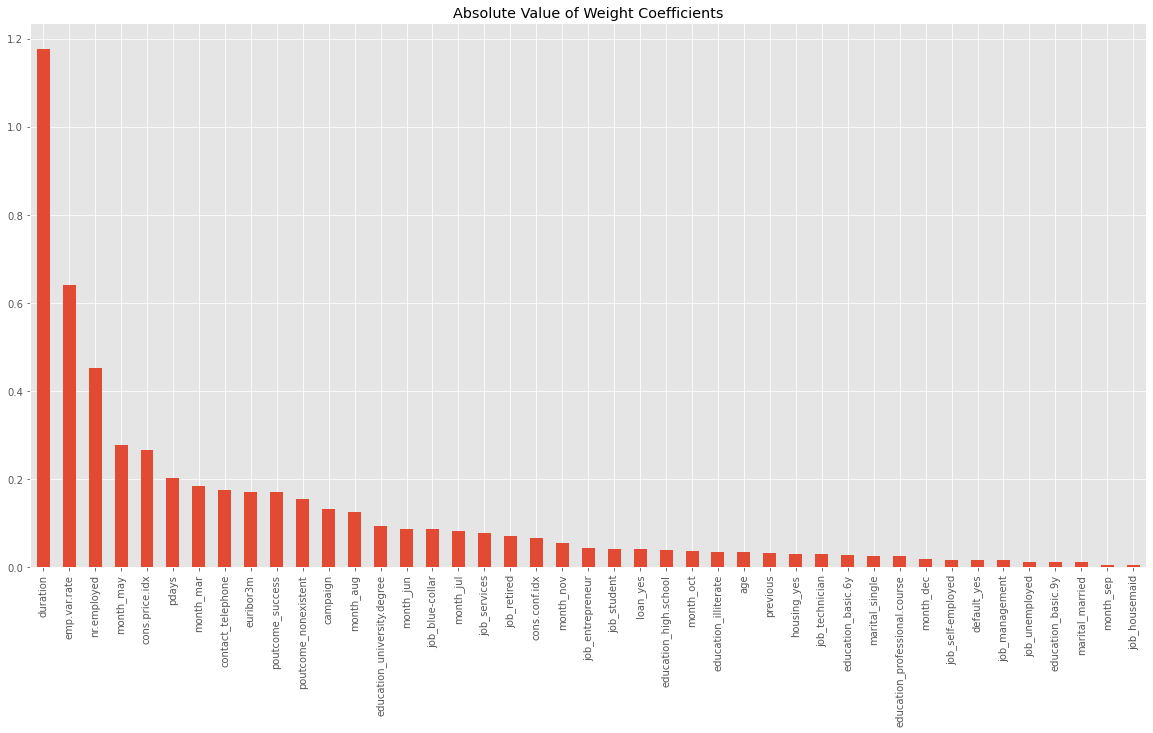

In [14]:
#Printing weights on a normalized scale
print('The following is a breakdown of the coefficient weights:\n')
# sort these attributes and spit them out
zip_vars = zip(abs(lr_clf.coef_.T),pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1).columns) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
#Plot magnitude of weights in descending order
#Grabbing column names for labels
#columns = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=0).columns

%matplotlib inline
plt.style.use('ggplot')

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

#Plotting weights
labels = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1).columns
weights = abs(pd.Series(lr_clf.coef_[0],index=labels)).sort_values(ascending=False)
weights.plot(kind='bar', title="Absolute Value of Weight Coefficients")
plt.show()

The following is a breakdown of the coefficient weights:

emp.var.rate has weight of 1.1759452776859622
duration has weight of 1.1506171784828054
cons.price.idx has weight of 0.49679723326329517
nr.employed has weight of 0.2922446964851542
month_may has weight of 0.2440419977682266
contact_telephone has weight of 0.19751003098100264
month_mar has weight of 0.19706705703335656
pdays has weight of 0.19684398963608604
poutcome_success has weight of 0.16945069489466813
month_aug has weight of 0.16593179824246096
poutcome_nonexistent has weight of 0.14531749730807186
campaign has weight of 0.11799265166692029
euribor3m has weight of 0.11053447618421902
education_university.degree has weight of 0.095494611872329
job_blue-collar has weight of 0.07858313957654058
month_nov has weight of 0.07653281277378343
job_services has weight of 0.07459604470243497
job_retired has weight of 0.06927431071421077
cons.conf.idx has weight of 0.06110739438818508
month_jul has weight of 0.06085618259747013
job_e

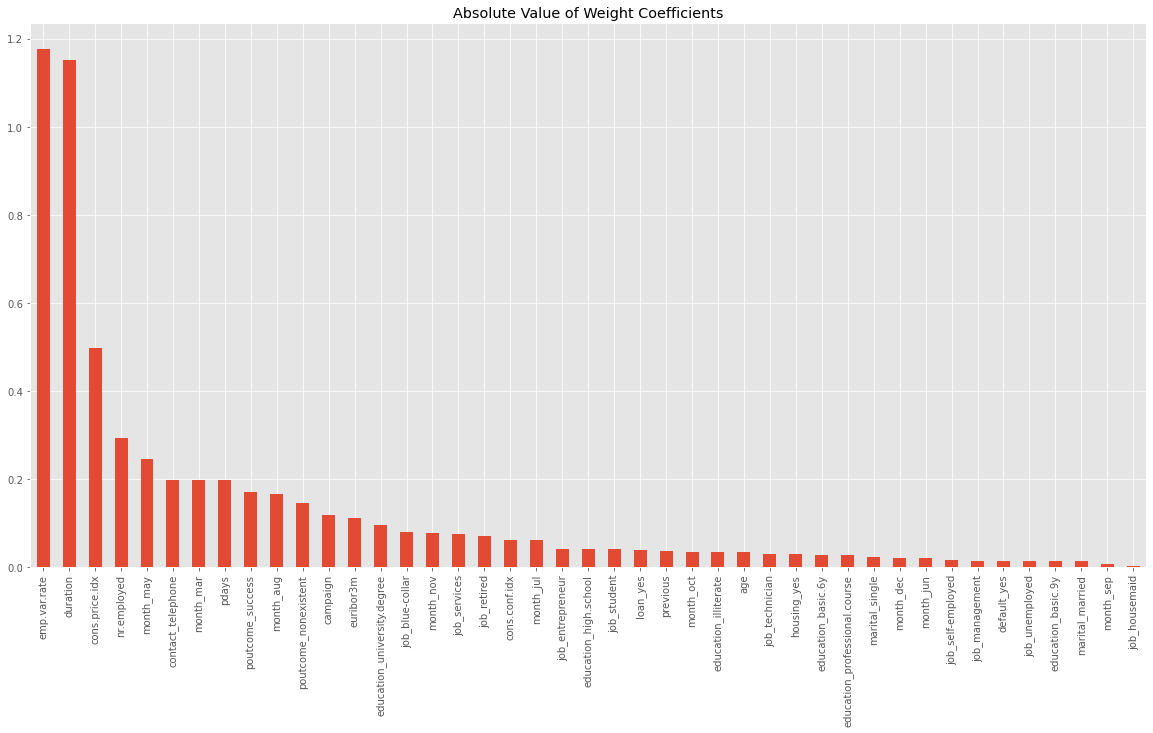

In [15]:
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear', max_iter=100)
lr_clf.fit(X_train_scaled,Y_train)
y_hat = lr_clf.predict(X_test_scaled)
print('The following is a breakdown of the coefficient weights:\n')
# sort these attributes and spit them out
zip_vars = zip(abs(lr_clf.coef_.T),pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1).columns) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
#Plot magnitude of weights in descending order
#Grabbing column names for labels
#columns = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=0).columns

%matplotlib inline
plt.style.use('ggplot')

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

#Plotting weights
labels = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1).columns
weights = abs(pd.Series(lr_clf.coef_[0],index=labels)).sort_values(ascending=False)
weights.plot(kind='bar', title="Absolute Value of Weight Coefficients")
plt.show()

/Users/chadkwong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.8904558871761233


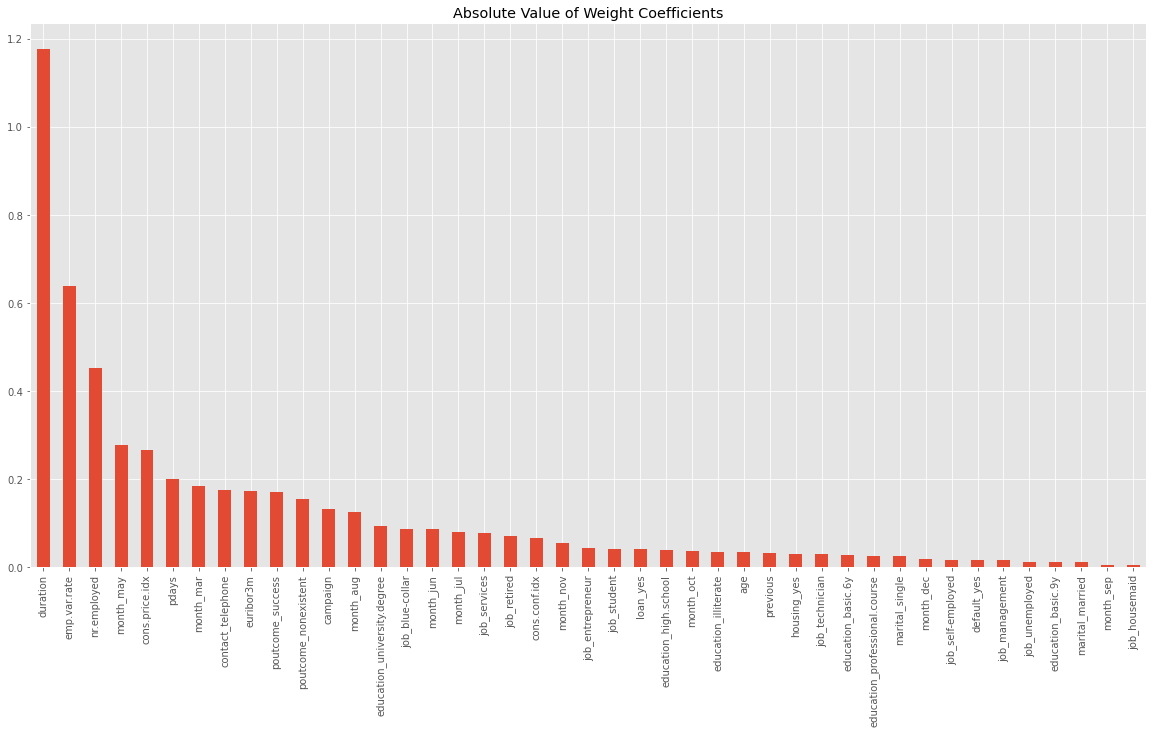

In [16]:
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='saga', max_iter=100)
lr_clf.fit(X_train_scaled,Y_train)
y_hat = lr_clf.predict(X_test_scaled)
acc = mt.accuracy_score(Y_test,y_hat)
print(acc)
labels = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1).columns
weights = abs(pd.Series(lr_clf.coef_[0],index=labels)).sort_values(ascending=False)
weights.plot(kind='bar', title="Absolute Value of Weight Coefficients")
plt.show()

## Gradient Based Alternatives

In [17]:
# # load another dataset (large) and train using various methods of gradient (and mini-batch)
# from __future__ import print_function

# 

In [18]:
%%time
#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,Y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),Y[train_idx])
    #Generating predictions
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    #Generating Confusion Matrix and Accuracy Score
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('SVM:', acc)

SVM: 0.8773368317481142
CPU times: user 1.28 s, sys: 47.1 ms, total: 1.32 s
Wall time: 425 ms


In [19]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent
log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,Y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),Y[train_idx])
    yhatLR = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(Y[test_idx],yhatLR)
    acc = mt.accuracy_score(Y[test_idx],yhatLR)

print('Logistic Regression:', acc)

Logistic Regression: 0.8829124303050181
CPU times: user 1.86 s, sys: 60.9 ms, total: 1.92 s
Wall time: 527 ms


In [20]:
%%time
# now lets use some of what we know from this class to reduce the dimensionality of the set
from sklearn.decomposition import PCA
n_components = 43

pca = PCA(n_components=n_components, svd_solver='randomized')

iterations = 150
log_sgd = SGDClassifier(
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', max_iter=iterations, n_jobs=-1, penalty='l2')

# you could also set this up in a pipeline
for train_idx, test_idx in cv.split(X,Y):
    log_sgd.fit(pca.fit_transform(X[train_idx]),Y[train_idx])
    yhat = log_sgd.predict(pca.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8883240406690718
CPU times: user 5.6 s, sys: 247 ms, total: 5.85 s
Wall time: 2.64 s


[[5011  258]
 [ 423  406]]


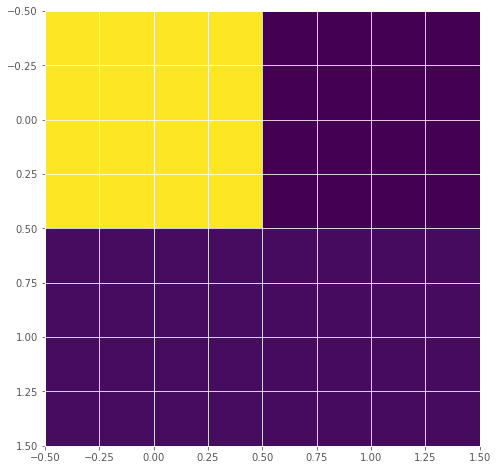

In [21]:
f = plt.figure(figsize=(8,8))
plt.imshow(conf)

#Confusion Matrix
print(conf)

In [22]:

yBinary = pd.Series(np.where(Y == 'yes', 1, 0),y.index)
yhatBinary = pd.Series(np.where(yhat == 'yes', 1, 0))
yhatLRBinary = pd.Series(np.where(yhatLR == 'yes', 1, 0))
logLossSVM = log_loss(Y[test_idx],yhatBinary)
logLossLR = log_loss(Y[test_idx],yhatLRBinary)

print('The Log Loss of the logistic regression model is: ', logLossLR)
print('The Log Loss of the SVM model is: ', logLossSVM)
print((logLossLR - logLossSVM)/logLossLR)

The Log Loss of the logistic regression model is:  4.044070829285209
The Log Loss of the SVM model is:  3.857184818148765
0.04621234865203295


When it comes to log-loss scores, the model with the lower score is superior. With this logic, we can see that the SVM model performs better by about 7% (3.5287 < 3.6023) when it comes to full models.

# SVM Extra

Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.